In [1]:
# Load & inspect the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load the dataset using pandas
data = pd.read_excel("elspot price 2013 2021.xlsx") 
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
# Select the proper time period for weekly aggreagation
data = data['2013-01-01':'2021-03-21'].resample('W').sum()
data.tail()

,FI
Date,
2021-02-21,423.09
2021-02-28,254.27
2021-03-07,263.71
2021-03-14,306.65
2021-03-21,256.62


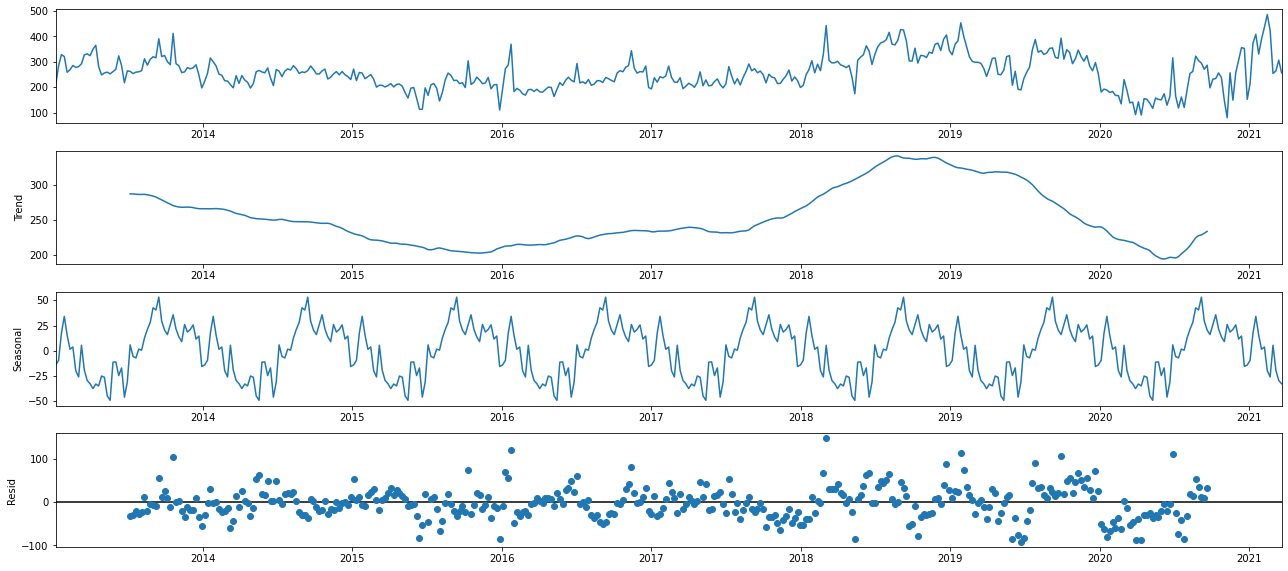

In [2]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu

# Tuloksena saan neljä kuviota:
# alkuperäinen aikasarja
# aikasarjasta erotettu trendi
# aikasarjan kausivaihtelu
# aikasarjan jäljelle jäänyt osa trendin ja kausivaihtelun poistamisen jälkeen.

# Visualizing Time Series Data
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive')
fig = decomposition.plot()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

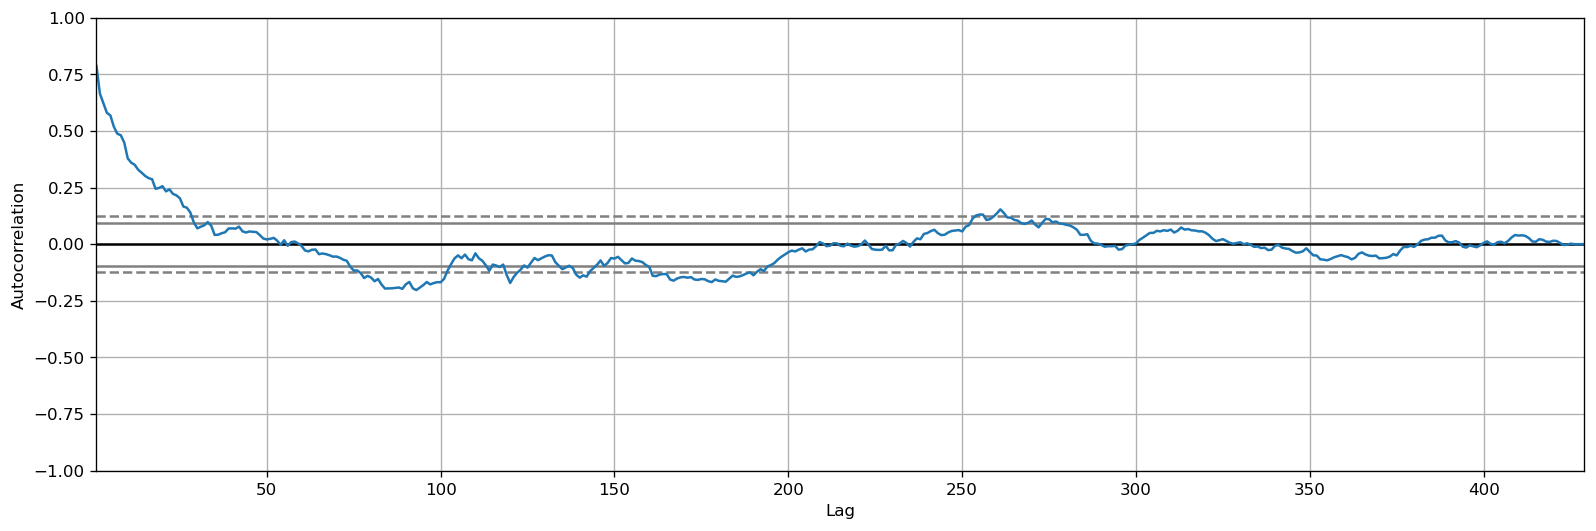

In [3]:
# Kausittaisuuden testaus
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(16,5), 'figure.dpi':120})
autocorrelation_plot(data.FI.tolist())

In [4]:
#Mallin sovitus
#Ennustemalli sovitetaan (fit()) dataan. Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi malli), joka sisältää monenlaista tietoa mallista.
#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.
#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.
#seasonal_periods-parametrille käytän arvoa 20, koska kausivaihtelu esiintyy 20 viikon jaksoissa.
#freq-parametrille käytän arvoa 'W', koska kyseessä on viikkodata. Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

malli = ExponentialSmoothing(data['FI'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 25, freq='W').fit()

C:\Users\Marko\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [5]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
data['Ennuste'] = malli.fittedvalues
data

,FI,Ennuste
Date,,
2013-01-06,207.38,297.490065
2013-01-13,284.60,264.504634
2013-01-20,328.39,299.062036
2013-01-27,320.88,310.004909
2013-02-03,258.64,301.397559
...,...,...
2021-02-21,423.09,389.283831
2021-02-28,254.27,375.999505
2021-03-07,263.71,332.965710


<AxesSubplot:xlabel='Date'>

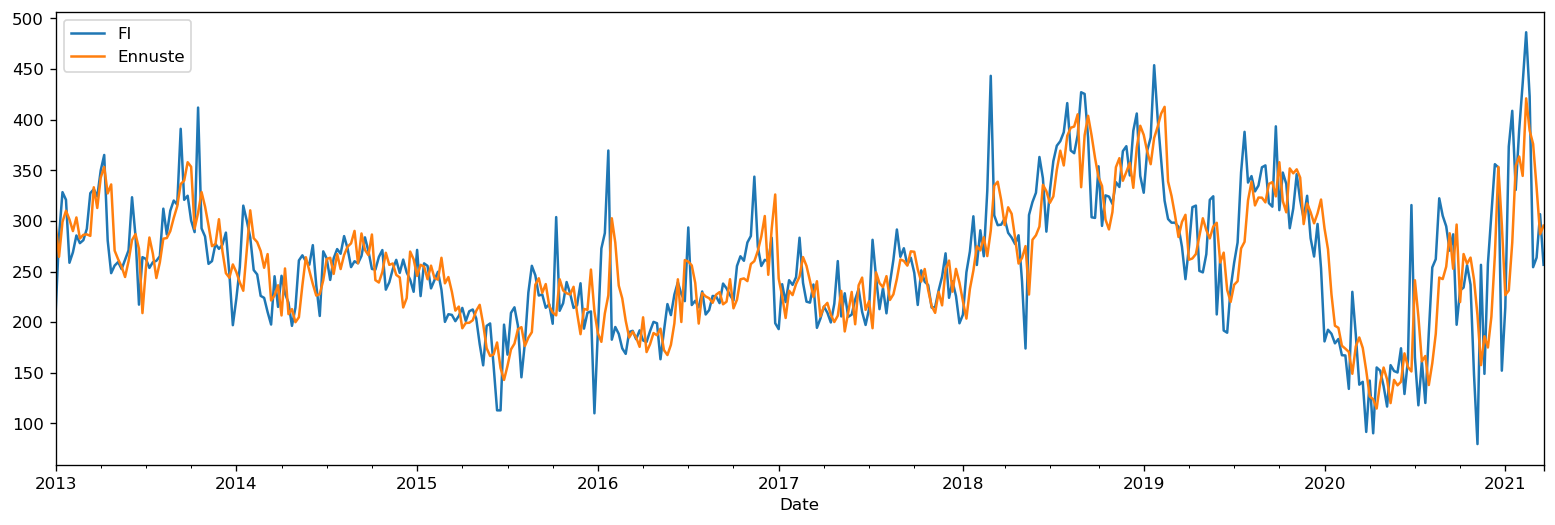

In [6]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
data.plot()

In [7]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
data['Ennustevirhe'] = malli.resid
data

,FI,Ennuste,Ennustevirhe
Date,,,
2013-01-06,207.38,297.490065,-90.110065
2013-01-13,284.60,264.504634,20.095366
2013-01-20,328.39,299.062036,29.327964
2013-01-27,320.88,310.004909,10.875091
2013-02-03,258.64,301.397559,-42.757559
...,...,...,...
2021-02-21,423.09,389.283831,33.806169
2021-02-28,254.27,375.999505,-121.729505
2021-03-07,263.71,332.965710,-69.255710


Text(0, 0.5, 'Ennustevirhe')

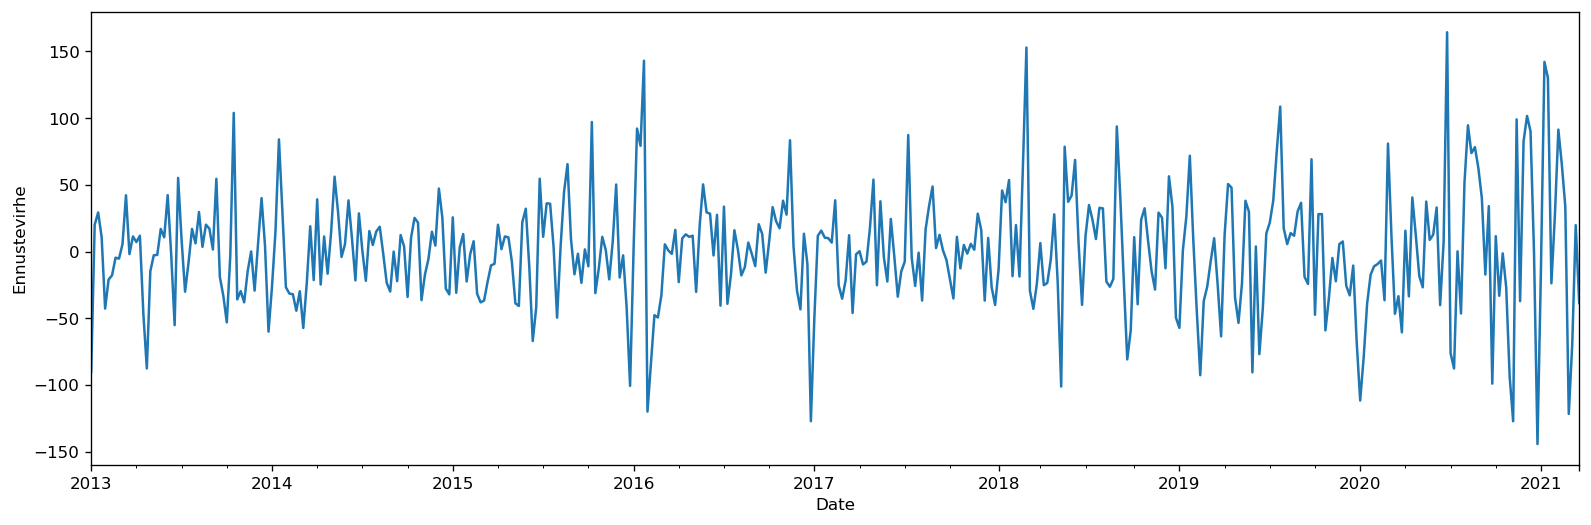

In [8]:
#Mallin tarkastelu
#Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
#ennustevirheiden aikasarjaa viivakaaviona
#ennusteiden ja toteutuneiden arvojen hajontakaaviota
#malliin liittyvää statistiikkaa, jonka saan summary()-toiminnolla.
#Huomaa erityisesti SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
data['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

In [9]:
# Mallin hyvyyden arviointi, miten ennusteet menee keskimäärin pieleen?
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Mean squared error', mean_squared_error(data['FI'], data['Ennuste']))
print('Mean absolute error', mean_absolute_error(data['FI'], data['Ennuste']))

Mean squared error 1863.706420295464
Mean absolute error 31.870312115505932


Text(0, 0.5, 'Toteutunut')

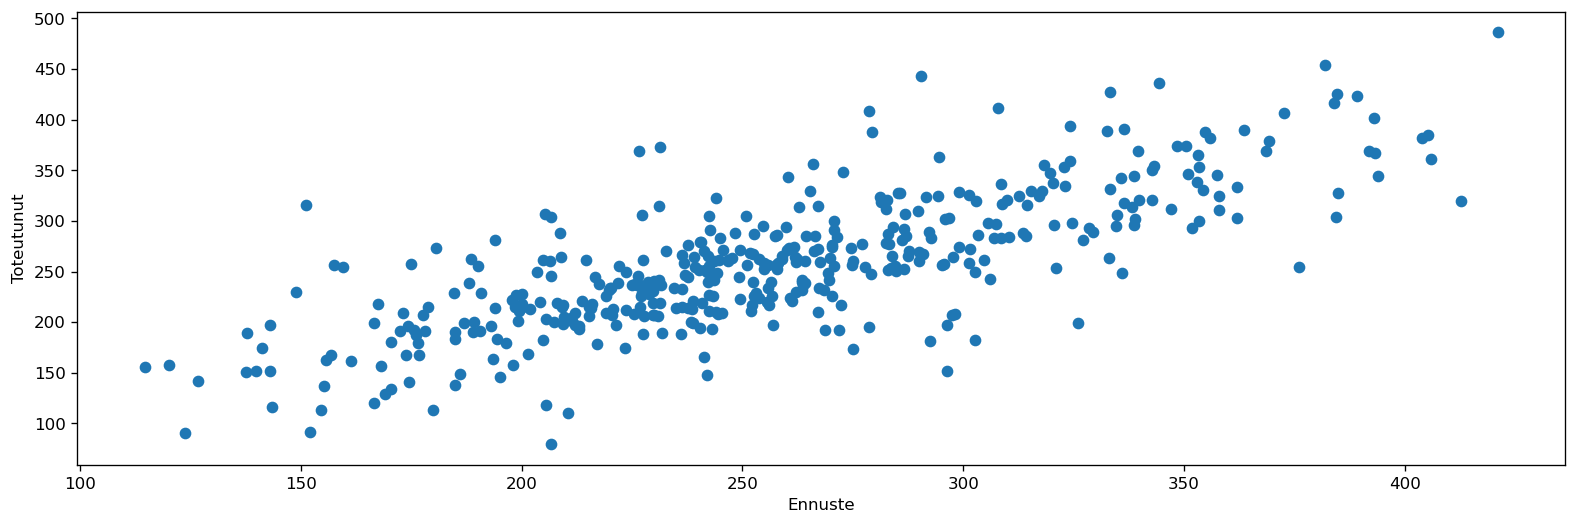

In [10]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = data['Ennuste'], y = data['FI'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut')

In [11]:
malli.summary()

Dep. Variable:,FI,No. Observations:,429
Model:,ExponentialSmoothing,SSE,799530.054
Optimized:,True,AIC,3288.508
Trend:,Additive,BIC,3406.291
Seasonal:,Multiplicative,AICC,3293.506
Seasonal Periods:,25,Date:,"Tue, 23 Mar 2021"
Box-Cox:,False,Time:,21:27:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3940300,alpha,True
smoothing_trend,0.0001227,beta,True


In [12]:
#Ennusteiden laskeminen
#Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
#Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
#Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.
#Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#Tarkistan viimeisen aikaleiman
data.tail()

,FI,Ennuste,Ennustevirhe
Date,,,
2021-02-21,423.09,389.283831,33.806169
2021-02-28,254.27,375.999505,-121.729505
2021-03-07,263.71,332.965710,-69.255710
2021-03-14,306.65,286.839192,19.810808
2021-03-21,256.62,295.286419,-38.666419


In [13]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('2021-03-28', periods = 24, freq = 'W')

# Ennusteet kuudelle viikolle
ennusteet = malli.forecast(24)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
2021-03-28,261.201178
2021-04-04,299.250231
2021-04-11,311.571706
2021-04-18,312.897455
2021-04-25,279.757806
2021-05-02,266.848293
2021-05-09,353.966003
2021-05-16,281.535035
2021-05-23,332.185938
2021-05-30,330.321673


<AxesSubplot:xlabel='Date'>

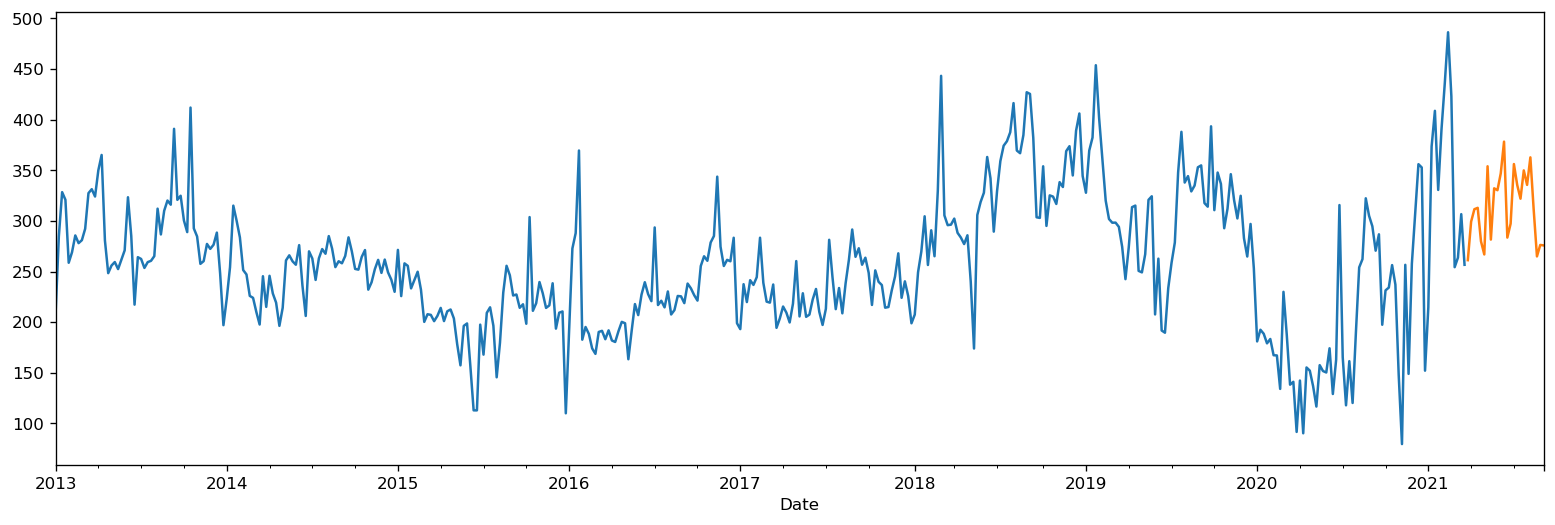

In [14]:
# Viivakaavio havainnoista
data['FI'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [15]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([data, df_ennuste])
df1

,FI,Ennuste,Ennustevirhe
2013-01-06,207.38,297.490065,-90.110065
2013-01-13,284.60,264.504634,20.095366
2013-01-20,328.39,299.062036,29.327964
2013-01-27,320.88,310.004909,10.875091
2013-02-03,258.64,301.397559,-42.757559
...,...,...,...
2021-08-08,NaN,362.770425,NaN
2021-08-15,NaN,311.389925,NaN
2021-08-22,NaN,264.917538,NaN
2021-08-29,NaN,276.239785,NaN


In [16]:
malli.params

{'smoothing_level': 0.3940300421738037,
 'smoothing_trend': 0.00012267581219032705,
 'smoothing_seasonal': 0.2203304539885717,
 'damping_trend': nan,
 'initial_level': 249.39594254542834,
 'initial_trend': -0.2601739341862783,
 'initial_seasons': array([1.19408813, 1.20702829, 1.32660511, 1.32546897, 1.27250066,
        1.29827138, 1.39996127, 1.33644835, 1.36413012, 1.37791742,
        1.36218675, 1.50556399, 1.41792036, 1.53423985, 1.56971538,
        1.43648822, 1.56476897, 1.406675  , 1.39412053, 1.36341686,
        1.31521446, 1.36388906, 1.45166299, 1.40099855, 1.33531092]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

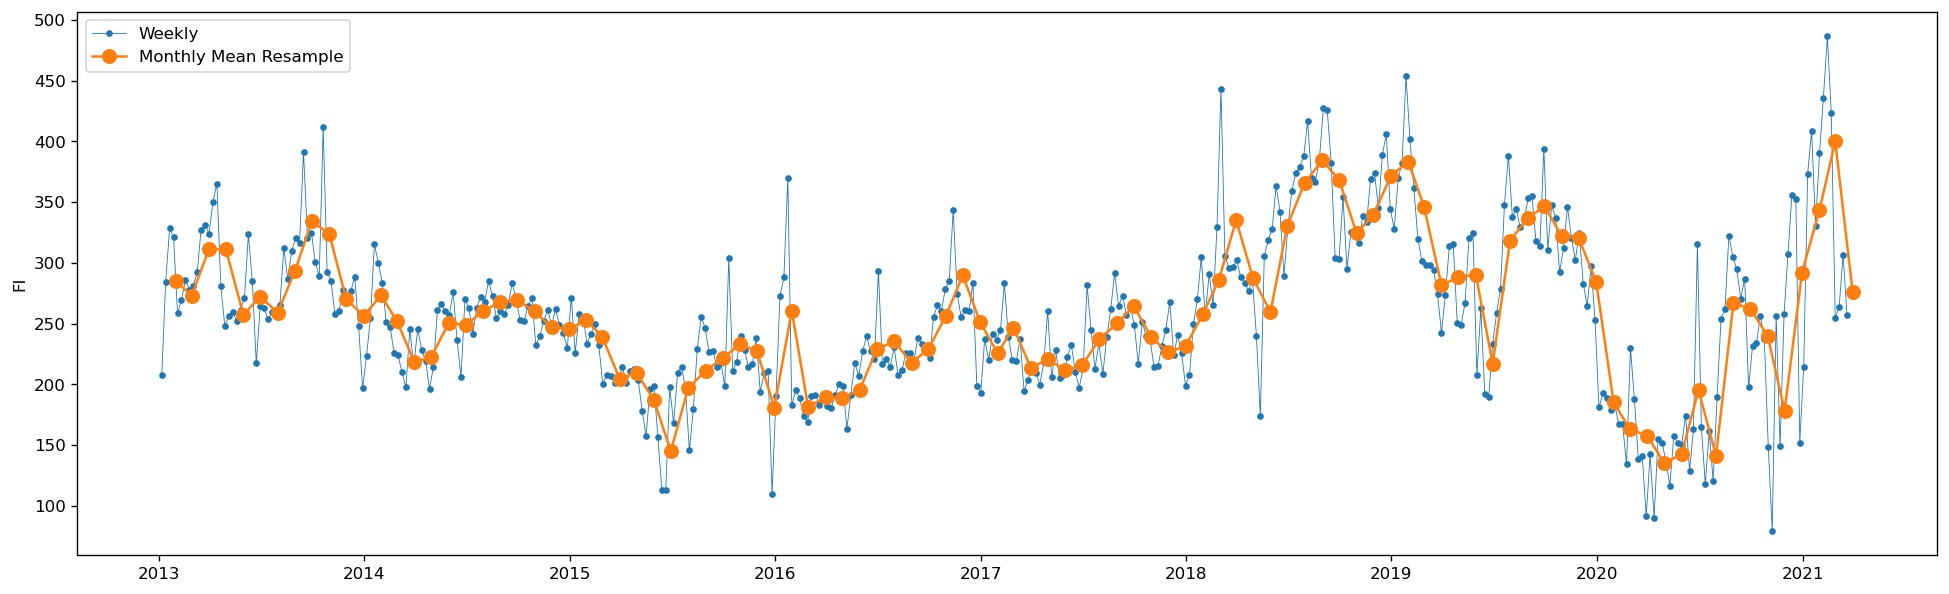

In [17]:
#Visualize the Data
import warnings
import matplotlib.pyplot as plt
y = data['FI']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('FI')
ax.legend();

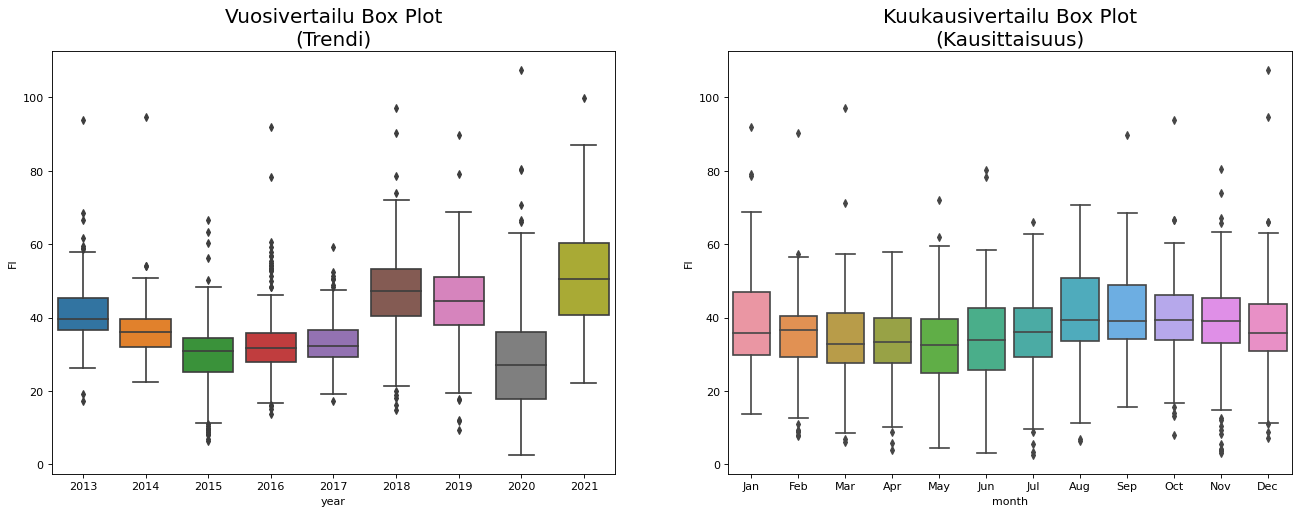

In [18]:
# Visuaalisaatio kausittaisuudesta

import seaborn as sns
# Boxplot kuukausi (kausittainen) ja vuosipohjainen trendi
# Import Data
df = pd.read_excel('elspot price 2013 2021.xlsx', index_col='Date')
df.reset_index(inplace=True)

# Prepare data
df['year'] = [d.year for d in df.Date]
df['month'] = [d.strftime('%b') for d in df.Date]
years = df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='FI', data=df, ax=axes[0])
sns.boxplot(x='month', y='FI', data=df.loc[~df.year.isin([2017, 2021]), :])

# Set Title
axes[0].set_title('Vuosivertailu Box Plot\n(Trendi)', fontsize=18); 
axes[1].set_title('Kuukausivertailu Box Plot\n(Kausittaisuus)', fontsize=18)
plt.show()